# Setup

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import tqdm
from scipy.stats import norm, lognorm, gamma, invgamma

Next block helps bypass folium display problems on VS Code, got this code from here: https://github.com/microsoft/vscode-jupyter/issues/17224#issuecomment-3679624559

In [2]:
from folium import Map
import base64
from IPython.display import IFrame, display

def show_folium_safe(m : Map, height=500):
    """
    Displays a Folium map in a safe IFrame using Base64 encoding.
    This avoids "Trusted" errors, file path issues, and CSS leakage.
    """
    # 1. Get the raw HTML string of the map
    html_content = m.get_root().render()
    
    # 2. Encode the HTML to base64
    # This allows us to put the entire map "inside" the URL string
    encoded = base64.b64encode(html_content.encode('utf-8')).decode('utf-8')
    
    # 3. Create a Data URI
    data_uri = f"data:text/html;charset=utf-8;base64,{encoded}"
    
    # 4. Display the IFrame
    # We use width='100%' to fill the cell width, but the CSS is trapped inside
    display(IFrame(src=data_uri, width="100%", height=height))

### Network downloads with OSMNx

In [3]:
# # Test Graph

# testGraph = ox.graph.graph_from_point((38.539078, -121.752065), dist=250, network_type='bike')
# fig, ax = ox.plot.plot_graph(testGraph)

# # Save the graph for offline access
# ox.io.save_graphml(testGraph, "testGraph.graphml")

In [4]:
# # Bounding box for the full Davis network
# bbox = (-121.794484891,38.5235690581,-121.6752063856,38.5755508478)

In [5]:
# # Bike Network Graph
# bikeGraph = ox.graph.graph_from_bbox(bbox, network_type='bike')
# fig, ax = ox.plot.plot_graph(bikeGraph)

# # Save the graph for offline access
# ox.io.save_graphml(bikeGraph, "bikeGraph.graphml")

In [6]:
# # Driving Network Graph
# driveGraph = ox.graph.graph_from_bbox(bbox, network_type='drive')
# fig, ax = ox.plot.plot_graph(driveGraph)

# # Save the graph for offline access
# ox.io.save_graphml(driveGraph, "driveGraph.graphml")

### Bike Network

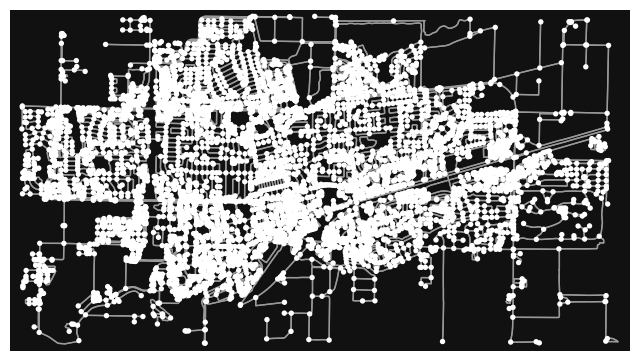

In [7]:
bikeGraph = ox.io.load_graphml("bikeGraph.graphml")
fig, ax = ox.plot.plot_graph(bikeGraph)

In [8]:
bikeNodes, bikeEdges = ox.graph_to_gdfs(bikeGraph)

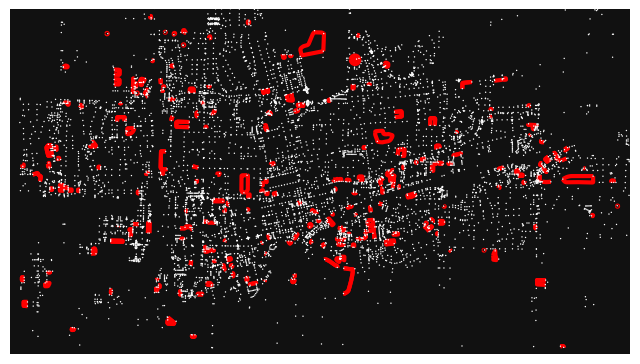

In [9]:
# Find edges with key 1 and 2
parallel_edge_keys = set()
for u, v, key in bikeGraph.edges(keys=True):
    if key in [1, 2]:
        parallel_edge_keys.add((u, v, key))

# Create subgraph with only those edges
subgraph = bikeGraph.copy()
edges_to_remove = [(u, v, k) for u, v, k in bikeGraph.edges(keys=True) 
                   if (u, v, k) not in parallel_edge_keys]
subgraph.remove_edges_from(edges_to_remove)

# Plot
fig, ax = ox.plot_graph(subgraph, node_size=1, edge_linewidth=3, 
                        edge_color='red', show=True, close=False)
ax.set_title('Bike Graph: Edges with Key = 1 or 2')
plt.show()

### Driving Network

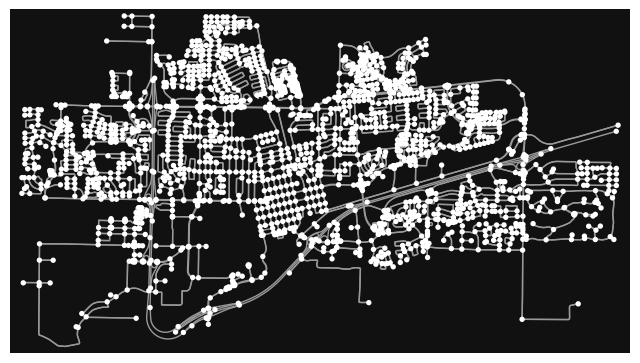

In [10]:
driveGraph = ox.io.load_graphml("driveGraph.graphml")
fig, ax = ox.plot.plot_graph(driveGraph)

In [11]:
driveNodes, driveEdges = ox.graph_to_gdfs(bikeGraph)

### Test Graph

In [12]:
testGraph = ox.io.load_graphml("testGraph.graphml")
testGraph = ox.routing.add_edge_speeds(testGraph)
testGraph = ox.routing.add_edge_travel_times(testGraph)
nodes, edges = ox.graph_to_gdfs(testGraph)

In [13]:
nodes

,y,x,street_count,geometry
osmid,,,,
95712770,38.539061,-121.750066,4,POINT (-121.75007 38.53906)
95716931,38.539897,-121.752174,3,POINT (-121.75217 38.5399)
95716932,38.540452,-121.750152,3,POINT (-121.75015 38.54045)
265024842,38.539079,-121.752408,3,POINT (-121.75241 38.53908)
271831022,38.540693,-121.753224,3,POINT (-121.75322 38.54069)
...,...,...,...,...
9156382464,38.540655,-121.754299,1,POINT (-121.7543 38.54066)
9159686623,38.540076,-121.750046,3,POINT (-121.75005 38.54008)
10684990777,38.538269,-121.754512,3,POINT (-121.75451 38.53827)


In [14]:
# The keys are "u" (start node), "v" (end node), and "key" (used for if there are multiple edges between node pairs).
# Because we don't have any multiple edges, we drop the "key" key to simplify our operations later.
# Theoretically, we could store higher probability and have the policy table store which edge was used, but that's not within my scope
edges

osmid   highway maxspeed  \
u           v           key                                              
95712770    277046658   0                  24411964  cycleway   15 mph   
            273245111   0                  24411964  cycleway   15 mph   
            273245096   0     [41889625, 991366978]  cycleway   15 mph   
            9159686623  0    [991366978, 391112883]  cycleway   15 mph   
95716931    559373141   0                  10746426  cycleway   15 mph   
...                                             ...       ...      ...   
10684990793 639324548   0                 218405222  cycleway      NaN   
            10684990777 0                1148407870  cycleway      NaN   
10684990794 10684990793 0                 218405222  cycleway      NaN   
            272014000   0                 218405222  cycleway      NaN   
            5674111324  0                1148407872   service   10 mph   

                                               name  oneway  reversed  \
u           v           key                                             
95712770    277046658   0           Hutchison Drive   False     False   
            273245111   0           Hutchison Drive   False      True   
            273245096   0                       NaN   False     False   
            9159686623  0                       NaN   False      True   
95716931    559373141   0    Peter J Shields Avenue   False     False   
...                                             ...     ...       ...   
10684990793 639324548   0                       NaN   False     False   
            10684990777 0                       NaN   False     False   
10684990794 10684990793 0                       NaN   False     False   
            272014000   0                       NaN   False      True   
            5674111324  0                       NaN   False     False   

                                 length  speed_kph  travel_time  \
u           v           key                                       
95712770    277046658   0     74.445826    24.1401    11.102066   
            273245111   0     55.648905    24.1401     8.298891   
            273245096   0    114.247851    24.1401    17.037720   
            9159686623  0    114.477385    24.1401    17.071950   
95716931    559373141   0     75.307218    24.1401    11.230525   
...                                 ...        ...          ...   
10684990793 639324548   0     23.446030    24.1401     3.496494   
            10684990777 0    101.269759    24.1401    15.102304   
10684990794 10684990793 0     17.320981    24.1401     2.583069   
            272014000   0     62.708203    24.1401     9.351640   
            5674111324  0    133.388708    16.0934    29.838278   

                                                                      geometry  \
u           v           key                                                      
95712770    277046658   0    LINESTRING (-121.75007 38.53906, -121.75092 38...   
            273245111   0    LINESTRING (-121.75007 38.53906, -121.74983 38...   
            273245096   0    LINESTRING (-121.75007 38.53906, -121.75006 38...   
            9159686623  0    LINESTRING (-121.75007 38.53906, -121.75007 38...   
95716931    559373141   0    LINESTRING (-121.75217 38.5399, -121.7521 38.5...   
...                                                                        ...   
10684990793 639324548   0    LINESTRING (-121.75362 38.53785, -121.75368 38...   
            10684990777 0    LINESTRING (-121.75362 38.53785, -121.75364 38...   
10684990794 10684990793 0    LINESTRING (-121.75343 38.53789, -121.75362 38...   
            272014000   0    LINESTRING (-121.75343 38.53789, -121.75333 38...   
            5674111324  0    LINESTRING (-121.75343 38.53789, -121.75345 38...   

                            junction lanes        service  
u           v           key                                
95712770    277046658   0        NaN   NaN            NaN  
            27

# Clean bike network

### Old Implementation

This is old code that modified the edges dataframe by assuming a single speed for all bicyclists. This is now deprecated due to the use of the empirical bike speed data.

In [15]:
def modifyEdgesBike(bikeSpeed, edgeGDF, unit='mph'):
    # Create a copy of the edge GeoDataFrame to avoid modifying the original
    modifiedEdges = edgeGDF.copy()
    
    # Validate unit input
    if unit not in ['mph', 'kph']:
        raise ValueError("Unit must be either 'mph' or 'kph'")
    
    # Convert bike speed to kph if necessary
    elif unit == 'mph':
        bikeSpeed = bikeSpeed * 1.60934  # convert mph to kph
    
    # Set new edge speeds
    modifiedEdges['speed_kph'] = bikeSpeed

    # Set new travel times in seconds
    modifiedEdges['travel_time'] = modifiedEdges['length'] / (modifiedEdges['speed_kph'] * 1000 / 3600)
    return modifiedEdges

In [16]:
testEdges = modifyEdgesBike(10, edges, unit='mph')

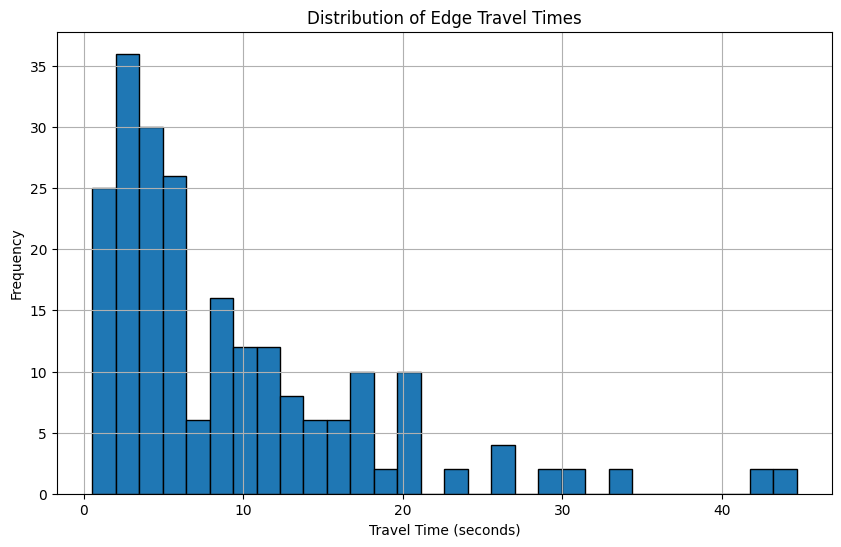

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
testEdges["travel_time"].hist(bins=30, ax=ax, edgecolor='black')
ax.set_xlabel('Travel Time (seconds)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Edge Travel Times')
plt.show()

### Using empirical bike speed data to create travel time distributions

In [18]:
# Read bike speed data
bikeSpeeds = pd.read_excel("Bike Speeds.xlsx")
bikeSpeeds = bikeSpeeds.set_index('Speed (mph)')
bikeSpeeds["Speed (m/s)"] = bikeSpeeds.index * 0.44704
bikeSpeeds

,2026-01-22 00:00:00,2026-01-23 00:00:00,2026-01-24 00:00:00,2026-01-25 00:00:00,2026-01-26 00:00:00,2026-01-27 00:00:00,2026-01-28 00:00:00,Total,Speed (m/s)
Speed (mph),,,,,,,,,
1,0,0,0,0,1,0,0,1,0.44704
2,1,1,0,0,3,2,0,7,0.89408
3,4,5,3,0,2,0,4,18,1.34112
4,3,4,2,0,2,8,7,26,1.78816
5,8,8,1,4,8,6,6,41,2.23520
6,24,23,6,10,20,18,22,123,2.68224
7,40,63,16,15,43,49,39,265,3.12928
8,120,122,43,42,110,118,128,683,3.57632
9,171,199,66,61,194,213,220,1124,4.02336


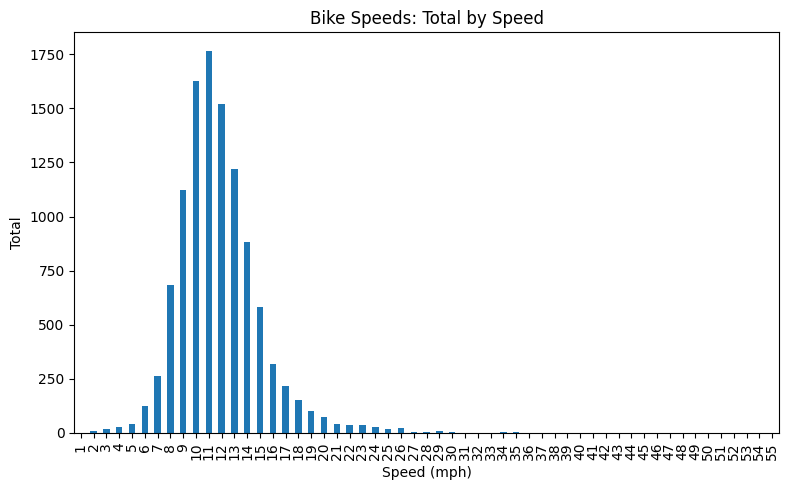

In [19]:
# Plot bike speed data
fig, ax = plt.subplots(figsize=(8, 5))
bikeSpeeds["Total"].plot(kind="bar", ax=ax)
ax.set_xlabel("Speed (mph)")
ax.set_ylabel("Total")
ax.set_title("Bike Speeds: Total by Speed")
plt.tight_layout()
plt.show()

The speed distribution seems to be approximately normal, but with a slight right skew. Because we want distributions for travel time rather than speed, we will hold off on fitting the distribution.

In [20]:
# # This code fits distributions to the bike speed data, which is not needed

# # Build a sample from the binned counts
# speeds = bikeSpeeds["Speed (m/s)"].to_numpy()
# counts = bikeSpeeds["Total"].to_numpy().astype(int)
# sample = np.repeat(speeds, counts)

# # Fit distributions
# norm_params = norm.fit(sample)
# lognorm_params = lognorm.fit(sample, floc=0)
# gamma_params = gamma.fit(sample, floc=0)

# # Plot histogram and fitted PDFs
# fig, ax = plt.subplots(figsize=(8, 5))
# ax.hist(sample, bins=55, density=True, alpha=0.4, edgecolor="black", label="Empirical")

# x = np.linspace(sample.min(), sample.max(), 300)
# ax.plot(x, norm.pdf(x, *norm_params), label="Normal fit")
# ax.plot(x, lognorm.pdf(x, *lognorm_params), label="Lognormal fit")
# ax.plot(x, gamma.pdf(x, *gamma_params), label="Gamma fit")

# ax.set_xlabel("Speed (m/s)")
# ax.set_ylabel("Density")
# ax.set_title("Bike Speed Distribution Fits")
# ax.legend()
# plt.tight_layout()
# plt.show()

# norm_params, lognorm_params, gamma_params

#### Testing fitting distribution for one edge

In [21]:
# Calculate travel time samples based on the bike speed data
speeds_ms = bikeSpeeds["Speed (m/s)"].to_numpy()
counts = bikeSpeeds["Total"].to_numpy().astype(int)
speeds_ms_expanded = np.repeat(speeds_ms, counts)
tt_sample = edges["length"].iloc[0] / speeds_ms_expanded # test edge

gamma_params = gamma.fit(tt_sample, floc=0)
norm_params = norm.fit(tt_sample)
lognorm_params = lognorm.fit(tt_sample, floc=0)
invgamma_params = invgamma.fit(tt_sample, floc=0)

In [22]:
gamma_params

(13.083137407169803, 0, np.float64(1.1585641599697638))

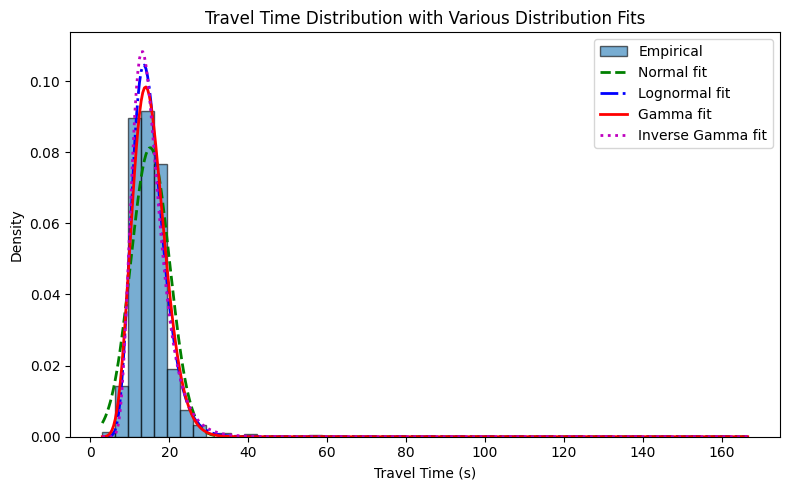

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(tt_sample, bins=50, density=True, edgecolor="black", alpha=0.6, label="Empirical")

x = np.linspace(tt_sample.min(), tt_sample.max(), 400)
ax.plot(x, norm.pdf(x, *norm_params), "g--", linewidth=2, label="Normal fit")
ax.plot(x, lognorm.pdf(x, *lognorm_params), "b-.", linewidth=2, label="Lognormal fit")
ax.plot(x, gamma.pdf(x, *gamma_params), "r-", linewidth=2, label="Gamma fit")
ax.plot(x, invgamma.pdf(x, *invgamma_params), "m:", linewidth=2, label="Inverse Gamma fit")

ax.set_xlabel("Travel Time (s)")
ax.set_ylabel("Density")
ax.set_title("Travel Time Distribution with Various Distribution Fits")
ax.legend()
plt.tight_layout()
plt.show()

Gamma distribution seems to be best for fitting the speed distributions. Initially the speed data was gamma distributed, so I expected the travel time distribution to follow an inverse gamma distribution. Howver, this doesn't seem to be the case given the test case.

#### Fitting gamma travel time distributions for all edges

In [24]:
def computeGammaParams(edges, speeds_ms_expanded):
    gamma_params_list = []
    for index, row in edges.iterrows():
        tt_distribution = row["length"] / speeds_ms_expanded  # calculate travel times for this edge with empirical speed data
        gamma_params = gamma.fit(tt_distribution, floc=0)
        gamma_params_list.append(gamma_params)
    edges['gamma_params'] = gamma_params_list
    return edges

In [25]:
# Create expanded speed samples
speeds_ms = bikeSpeeds["Speed (m/s)"].to_numpy()
counts = bikeSpeeds["Total"].to_numpy().astype(int)
speeds_ms_expanded = np.repeat(speeds_ms, counts)

# Calculate gamma parameters for all edges
edges = computeGammaParams(edges, speeds_ms_expanded)

# Clean car network

This might have to be a fully manual process, as different road types should have different distribution types, so that will need to be assigned manually

# Create Travel Time Distributions

In [26]:
# def createTTDistribution(endNode, edgesGDF, timeBudget, interval=1, distributionType='normal', params={}):
#     # Create time range and intervals
#     maxInterval = int(timeBudget / interval)
#     x = np.linspace(0, timeBudget, maxInterval + 1)

#     # Initialize the travel time distribution DataFrame
#     TTDistributions = pd.DataFrame(
#         index=edgesGDF.index,
#         columns=np.arange(0, maxInterval + 1)
#     )

#     # Populate the TTDistribution DataFrame based on the specified distribution type
#     for index, row in edgesGDF.iterrows():
#         mu = row["travel_time"]  # mean travel time in seconds
#         sigma = 0.2 * mu  # standard deviation as 20% of mean travel time

#         # Create normal distribution for travel time
#         norm_dist = norm(loc=mu, scale=sigma)

#         # Discretize PDF values over the time range
#         pdf_values = norm_dist.pdf(x) * interval  # scale by time unit for discretization

#         # Store the PDF values in the TTDistribution column
#         TTDistributions.loc[index] = pdf_values
#     return TTDistributions

In [27]:
# Time range and interval creation
# For testing purposes, use 5 minutes and discretize into 0.1 second intervals
timeBudget = 300  # 5 minutes in seconds
interval = 1 # 1 second intervals
maxInterval = int(timeBudget / interval)
x = np.linspace(0, timeBudget, maxInterval + 1)

In [28]:
# Based on time range and interval, create travel time distributions for each edge using the gamma params
TTDistributions = pd.DataFrame(
    index=edges.index,
    columns=np.arange(0, maxInterval + 1)
)

for index, row in edges.iterrows():
    gamma_params = row["gamma_params"]  # access gamma parameters for the edge
    distribution = gamma.pdf(x, *gamma_params)  # create gamma distribution PDF values over the time range
    pdf_values = distribution * interval  # scale by time unit for discretization

    # Store the PDF values in the TTDistribution column
    TTDistributions.loc[index] = pdf_values

In [29]:
TTDistributions

0         1         2         3         4    \
u           v           key                                                
95712770    277046658   0    0.0       0.0       0.0  0.000011  0.000147   
            273245111   0    0.0       0.0  0.000005  0.000202  0.002063   
            273245096   0    0.0       0.0       0.0       0.0  0.000002   
            9159686623  0    0.0       0.0       0.0       0.0  0.000002   
95716931    559373141   0    0.0       0.0       0.0   0.00001  0.000132   
...                          ...       ...       ...       ...       ...   
10684990793 639324548   0    0.0  0.000058  0.016357  0.141644  0.295535   
            10684990777 0    0.0       0.0       0.0       0.0  0.000007   
10684990794 10684990793 0    0.0  0.001164  0.123683  0.406359  0.321681   
            272014000   0    0.0       0.0  0.000001  0.000063  0.000727   
            5674111324  0    0.0       0.0       0.0       0.0       0.0   

                                  5         6         7         8         9    \
u           v           key                                                     
95712770    277046658   0    0.000919  0.003511  0.009539  0.020201  0.035368   
            273245111   0    0.009637  0.027493  0.055806  0.088294  0.115489   
            273245096   0    0.000015  0.000079  0.000288  0.000825  0.001952   
            9159686623  0    0.000015  0.000077  0.000283  0.000811   0.00192   
95716931    559373141   0    0.000831  0.003205  0.008793  0.018807  0.033253   
...                               ...       ...       ...       ...       ...   
10684990793 639324548   0    0.282712  0.165143  0.068635  0.022235  0.005955   
            10684990777 0    0.000051  0.000247  0.000844  0.002245  0.004941   
10684990794 10684990793 0    0.116753  0.025876   0.00408  0.000501  0.000051   
            272014000   0    0.003869   0.01257  0.029057  0.052355  0.077987   
            5674111324  0    0.000003  0.000017  0.000067  0.000207  0.000532   

                             ...  291  292  293  294  295  296  297  298  299  \
u           v           key  ...                                                
95712770    277046658   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            273245111   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            273245096   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            9159686623  0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
95716931    559373141   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
10684990793 639324548   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            10684990777 0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10684990794 10684990793 0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            272014000   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            5674111324  0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                             300  
u           v           key       
95712770    277046658   0    0.0  
            273245111   0    0.0  
            273245096   0    0.0  
            9159686623  0    0.0  
95716931    559373141   0    0.0  
...                          ...  
10684990793 639324548   0    0.0  
            10684990777 0    0.0  
10684990794 10684990793 0    0.0  
            272014000   0    0.0  
            5674111324  0    0.0  

[221 rows x 301 columns]

### Fixing distribution integrity

In [30]:
sums = TTDistributions.sum(axis=1)  # Check that the rows sum to approximately 1
edges["sums"] = sums
sums

u            v            key
95712770     277046658    0           1.0
             273245111    0           1.0
             273245096    0           1.0
             9159686623   0           1.0
95716931     559373141    0           1.0
                                   ...   
10684990793  639324548    0      0.999989
             10684990777  0           1.0
10684990794  10684990793  0      1.000153
             272014000    0           1.0
             5674111324   0           1.0
Length: 221, dtype: object

Because of some edges with short lengths, some distributions are summing to significantly above or below 0. This section here remedies this problem by identifying flawed distributions and replacing them with a uniform distribution for simplicity. The threshold used is a distribution summing to more than 1.0001 or less than 0.9999, in other words abs(error) > 0.0001.

In [31]:
errors = sums[abs(1 - sums) > 0.0001]

In [32]:
sums[errors.index]

u            v            key
95716931     9147059880   0      0.953182
95716932     3942697372   0      1.000865
272013491    272014138    0      1.000366
272013500    9147072726   0      1.001405
272013998    5598405315   0      1.237157
                                   ...   
9156382463   9156382464   0      1.000425
9156382464   9156382463   0      1.000425
9159686623   3942441819   0      1.000643
10684990793  10684990794  0      1.000153
10684990794  10684990793  0      1.000153
Length: 72, dtype: object

After investigating the actual travel time distributions, it's clear that these edges are so short that the chosen interval of 1 second isn't suitable to properly capture a proper probability distribution function, leading to these errors. Checking the edge lengths and travel times shows the same thing.

In [33]:
TTDistributions.loc[errors.index]

,,,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
u,v,key,,,,,,,,,,,,,,,,,,,,,
95716931,9147059880,0,0.0,0.197572,0.681104,0.072619,0.001866,0.000022,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95716932,3942697372,0,0.0,0.003557,0.233278,0.473154,0.231232,0.05181,0.007089,0.00069,0.000052,0.000003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272013491,272014138,0,0.0,0.001911,0.16558,0.443826,0.286638,0.084875,0.015346,0.001974,0.000198,0.000016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272013500,9147072726,0,0.0,0.005504,0.291549,0.477621,0.188526,0.034118,0.00377,0.000296,0.000018,0.000001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272013998,5598405315,0,0.0,1.131469,0.105385,0.000304,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156382463,9156382464,0,0.0,0.002104,0.174951,0.449868,0.278722,0.079174,0.013733,0.001695,0.000163,0.000013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9156382464,9156382463,0,0.0,0.002104,0.174951,0.449868,0.278722,0.079174,0.013733,0.001695,0.000163,0.000013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9159686623,3942441819,0,0.0,0.002818,0.205839,0.464984,0.253084,0.063156,0.009624,0.001043,0.000088,0.000006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
edges.loc[errors.index, ["length","travel_time", "gamma_params", "sums"]]


,,,length,travel_time,gamma_params,sums
u,v,key,,,,
95716931,9147059880,0,9.002372,1.342519,"(13.08313740716978, 0, 0.14009954229125646)",0.953182
95716932,3942697372,0,15.328104,2.285872,"(13.083137407169803, 0, 0.23854381998408844)",1.000865
272013491,272014138,0,16.420090,2.448719,"(13.083137407169676, 0, 0.2555378701937791)",1.000366
272013500,9147072726,0,14.585024,2.175057,"(13.083137407169854, 0, 0.22697962589999968)",1.001405
272013998,5598405315,0,5.977922,0.891484,"(13.08313740716974, 0, 0.0930314908177224)",1.237157
...,...,...,...,...,...,...
9156382463,9156382464,0,16.247672,2.565536,"(13.0831374071699, 0, 0.25285461456645714)",1.000425
9156382464,9156382463,0,16.247672,2.565536,"(13.0831374071699, 0, 0.25285461456645714)",1.000425
9159686623,3942441819,0,15.732357,2.346158,"(13.083137407169854, 0, 0.24483501041853584)",1.000643


In [35]:
edges.loc[errors.index, ["length","travel_time", "gamma_params", "sums"]]["travel_time"]

u            v            key
95716931     9147059880   0      1.342519
95716932     3942697372   0      2.285872
272013491    272014138    0      2.448719
272013500    9147072726   0      2.175057
272013998    5598405315   0      0.891484
                                   ...   
9156382463   9156382464   0      2.565536
9156382464   9156382463   0      2.565536
9159686623   3942441819   0      2.346158
10684990793  10684990794  0      2.583069
10684990794  10684990793  0      2.583069
Name: travel_time, Length: 72, dtype: float64

##### Visual error edges identification check

Good validation, all of the visually shorter edges are the ones with problematic distributions.

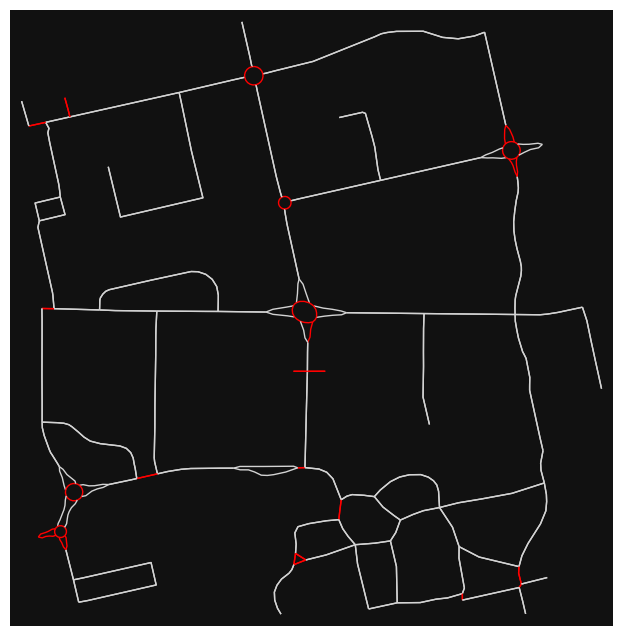

In [36]:
plotEdges = edges.copy()
plotEdges["color"] = np.where(plotEdges.index.isin(errors.index), 'red', 'lightgray')
plotGraph = ox.graph_from_gdfs(nodes, plotEdges)

# Plotting edges with errors highlighted
fig, ax = ox.plot_graph(
    plotGraph,
    node_size=0,
    edge_color=plotEdges['color'],
    # linewidths argument is a mess so I'm just skipping it
    show=False,
    close=False,
)

# # Adding text for error edges
# for index, data in edges.iterrows():
#     if index in errors.index:
#         text = f"{errors.loc[index]:.1f}"
#         c = data['geometry'].centroid
#         ax.annotate(text, (c.x, c.y), fontsize=8, color='white',
#                    ha='center', va='center', zorder=100)

plt.show()

##### Fixing the errors

To get rid of problematic distributions and simplify the graph, I'm just setting an arbitrary 100% chance for the nearest integer travel time when dividing by the average speed from bike speed data.

It shouldn't really affect the algorithm because of the low edge travel times relative to all the other edges--right now the biggest edges that we're setting with these arbitrary functions are at most around 3 seconds long.

In [37]:
speeds_ms_expanded.mean()

np.float64(5.296576221735959)

In [38]:
edges["mean_travel_time"] = edges["length"] / speeds_ms_expanded.mean()
edges.loc[errors.index]["mean_travel_time"]

u            v            key
95716931     9147059880   0      1.699659
95716932     3942697372   0      2.893965
272013491    272014138    0      3.100133
272013500    9147072726   0      2.753670
272013998    5598405315   0      1.128639
                                   ...   
9156382463   9156382464   0      3.067580
9156382464   9156382463   0      3.067580
9159686623   3942441819   0      2.970288
10684990793  10684990794  0      3.270222
10684990794  10684990793  0      3.270222
Name: mean_travel_time, Length: 72, dtype: float64

In [39]:
len(errors.index)

72

In [40]:
TTDistributions.loc[errors.index] = 0
for index in errors.index:
    mean_travel_time = edges.loc[index, "mean_travel_time"]
    rounded_mean_travel_time = round(mean_travel_time)
    if rounded_mean_travel_time == 0:
        TTDistributions.loc[index, 1] = 1
    else:
        TTDistributions.loc[index, rounded_mean_travel_time] = 1
TTDistributions.loc[errors.index]

,,,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
u,v,key,,,,,,,,,,,,,,,,,,,,,
95716931,9147059880,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95716932,3942697372,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272013491,272014138,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272013500,9147072726,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272013998,5598405315,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156382463,9156382464,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9156382464,9156382463,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9159686623,3942441819,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
TTDistributions[TTDistributions[0] == 1]

,,,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
u,v,key,,,,,,,,,,,,,,,,,,,,,


Check the new pdf sums, there should be no edges with a pdf sum with more than 1.05 or less than 0.95 

In [42]:
sums = TTDistributions.sum(axis=1)  # Check that the rows sum to approximately 1
edges["sums"] = sums
sums

u            v            key
95712770     277046658    0           1.0
             273245111    0           1.0
             273245096    0           1.0
             9159686623   0           1.0
95716931     559373141    0           1.0
                                   ...   
10684990793  639324548    0      0.999989
             10684990777  0           1.0
10684990794  10684990793  0             1
             272014000    0           1.0
             5674111324   0           1.0
Length: 221, dtype: object

In [43]:
sums[abs(1 - sums) > 0.0001]

Series([], dtype: object)

# Algorithm

In [44]:
# Test endNode
endNode = 301036896
# endNode = 7471168568

In [45]:
# Function to solve for probability and policy tables given an endNode, TTDistributions, timeBudget, and interval
# timeBudget and interval are created with TTDistributions above, do I want to pass them as part of TTDistributions?
def SOTAsolve(endNode, TTDistributions, timeBudget, interval, nodes):
    # Recalculate maxInterval based on timeBudget and interval
    maxInterval = int(timeBudget / interval)
    
    # Initilize probability and policy tables
    initializeStart = time.time() # for timing how long initialization takes
    probabilities = pd.DataFrame(
        columns= np.arange(0, maxInterval + 1),
        index=nodes.index,
    )

    probabilities.index.names = ['Start node']
    probabilities.iloc[:,:] = 0
    probabilities.loc[endNode,] = 1
    
    policy = pd.DataFrame(
        columns= np.arange(0, maxInterval + 1),
        index=nodes.index,
    )
    policy.index.names = ['Start node']
    initializeEnd = time.time() # for timing how long initialization takes
    print(f"Time to initialize policy and probabilities: {initializeEnd - initializeStart} seconds")

    # Iterate through all time budgets and solve for optimal probabilities and policies
    algorithmStart = time.time() # for timing how long the algorithm takes
    for tb in tqdm.tqdm(np.arange(1, maxInterval + 1), unit=" iterations (time budgets)"):

        # Iterate through the possible start nodes
        for startNode in policy.index:
            
            # ignore endNode
            if startNode == endNode:
                continue

            # Calculate optimal probability of reaching the end node given the start node, end node, and time budget
            # Find relevant travel time distribution values
            distributionCalc = TTDistributions.loc[startNode].iloc[:,1:tb+1]
            # Reverse travel time distribution values matrix
            distributionCalc = distributionCalc.iloc[:, ::-1]
            # Find relevant probabilities to adjacent nodes
            adjacentNodes = distributionCalc.index
            # Create probabilitiesCalc DataFrame with MultiIndex to match distributionCalc
            endNodes = adjacentNodes.get_level_values("v")
            timeRange = range(0, tb)
            probabilitiesCalc = probabilities.loc[endNodes, timeRange].copy()
            probabilitiesCalc.index = adjacentNodes
            # Calculate the element-wise product of the two matrices
            result = distributionCalc.values * probabilitiesCalc.values
            # Sum the product to find probability of getting to end node based on which adjacent node is traveled to next
            row_sums = pd.Series(np.sum(result, axis=1), index=adjacentNodes)

            # Store the optimal probability, don't allow it to exceed 1
            probabilities.loc[startNode, tb] = min(row_sums.max(), 1.0)
            
            # Store the optimal policy
            if np.nanmax(row_sums) == 0:
                policy.loc[startNode, tb] = np.nan
            else:
                policy.loc[startNode, tb] = str(row_sums.idxmax())
    
    algorithmEnd = time.time() # for timing how long the algorithm takes
    print(f"Time to run algorithm: {algorithmEnd - algorithmStart} seconds")

    # Return the probability and policy tables
    return probabilities, policy

In [46]:
probabilities, policy = SOTAsolve(endNode, TTDistributions, timeBudget, interval, nodes=nodes)

Time to initialize policy and probabilities: 0.0033490657806396484 seconds


100%|██████████| 300/300 [00:16<00:00, 18.08 iterations (time budgets)/s]

Time to run algorithm: 16.605148792266846 seconds


In [47]:
display(probabilities, policy)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,
95712770,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998
95716931,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998
95716932,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998
265024842,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999
271831022,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156382464,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998
9159686623,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998
10684990777,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,
95712770,NaN,NaN,NaN,"(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))",...,"(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))","(np.int64(273245111), np.int64(0))"
95716931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))"
95716932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))"
265024842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(np.int64(3942353116), np.int64(0))","(np.int64(3942353116), np.int64(0))",...,"(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))"
271831022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156382464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))"
9159686623,NaN,NaN,NaN,NaN,"(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))",...,"(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))"
10684990777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"(np.int64(10684990793), np.int64(0))","(np.int64(10684990793), np.int64(0))","(np.int64(10684990793), np.int64(0))","(np.int64(10684990793), np.int64(0))","(np.int64(10684990793), np.int64(0))","(np.int64(10684990793), np.int64(0))","(np.int64(10684990793), np.int64(0))

# Debugging

In [48]:
weirdNodes = probabilities[abs(probabilities[300] - 1) > 0.001]
weirdNodes

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,


In [49]:
probabilityErrors = probabilities[abs(probabilities[300] - 1) > 0.1].loc[:,300]
nodes["finalProb"] = probabilities[300]
nodes["finalPolicy"] = policy[300]

In [50]:
m = edges.explore(tiles="cartodbpositron")
nodes.explore(m = m, marker_kwds={"radius": 8}, column="finalProb", cmap="coolwarm_r")


# Use the safe function to display it
show_folium_safe(m)

In [51]:
weirdNodes.index

Index([], dtype='int64', name='Start node')

In [52]:
probabilities.loc[weirdNodes.index]

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,


In [53]:
policy.loc[weirdNodes.index]

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,
